In [1]:
import numpy as np
import pandas as pd
import re
import requests
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
%matplotlib inline

HEADERS = {
            'user-agent': ('Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36'), 
            'Dnt': ('1'),
            'Accept-Encoding': ('gzip, deflate, sdch'),
            'Accept-Language': ('en'),
            'origin': ('http://stats.nba.com')
            }

In [2]:
P_URL = 'http://stats.nba.com/stats/{}'

season = 2017
endpoint = 'commonallplayers'

p_master=None

seasonstr = str(season)+'-'+str(season+1)[2:]

json =  requests.get(P_URL.format(endpoint),
                     params= {'LeagueID': '00',
                              'Season': seasonstr,
                              'IsOnlyCurrentSeason': 0
                             },
                     headers = HEADERS
                    ).json()

headers = json['resultSets'][0]['headers']
values = json['resultSets'][0]['rowSet']

df = pd.DataFrame(values, columns = headers)

df['season'] = season
cols = ['PERSON_ID', 'DISPLAY_FIRST_LAST']

p_master = df[cols].copy()

In [3]:
PT_URL = 'https://stats-prod.nba.com/wp-json/statscms/v1/synergy/player'

categories = ['Transition', 'Isolation', 'PRBallHandler', 'PRRollMan', 'Postup',
              'Spotup', 'Handoff', 'Cut', 'OffScreen', 'OffRebound', 'Misc'
             ]
seasons = [2015,2016, 2017]
sides = ['offensive', 'defensive']

pt_master=None
for season in seasons:
    seasondf = None
    for side in sides:
        for category in categories:
            try:
                json =  requests.get(PT_URL,
                                     params={'season': season,
                                             'names': side,
                                             'category':category,
                                             'seasonType': 'Reg',
                                             'limit':500                             
                                             },
                                     headers = HEADERS
                                    ).json()

                headers = json['results'][0].keys()
                values = json['results']

                df = pd.DataFrame(values, columns = headers)

                posscol = side[0] + '_' + category + '_' + 'Poss'
                df[posscol] = df['Poss']
                cols = ['PlayerIDSID', 'season', posscol]
                if seasondf is None:
                    seasondf = df[cols].copy()
                else:
                    seasondf = pd.merge(df[cols], seasondf, how='outer',
                                         on=['PlayerIDSID', 'season'])
            except:
                pass
    if pt_master is None:
        pt_master = seasondf.copy()
    else:
        pt_master = pd.concat([pt_master, seasondf], ignore_index=True)
        
pt_master = pt_master.groupby(['PlayerIDSID', 'season']).sum().reset_index()
pt_master = pd.merge(pt_master, p_master, how='inner', left_on='PlayerIDSID',
                     right_on='PERSON_ID')

In [4]:
T_URL = 'http://stats.nba.com/stats/{}'

categories_dict = {'Drives':['DRIVES', 'DRIVE_PASSES', 'MIN'],
                   'CatchShoot':['CATCH_SHOOT_FGA', 'CATCH_SHOOT_FG3A'],
                   'Passing':['PASSES_MADE', 'PASSES_RECEIVED'],
                   'Possessions':['AVG_SEC_PER_TOUCH', 'AVG_DRIB_PER_TOUCH',
                                  'ELBOW_TOUCHES', 'POST_TOUCHES', 'PAINT_TOUCHES', 'TOUCHES'],
                   'PullUpShot':['PULL_UP_FGA', 'PULL_UP_FG3A'],
                   'Rebounding':['OREB_CHANCES', 'AVG_OREB_DIST',
                                 'DREB_CHANCES', 'AVG_DREB_DIST'],
                   'Defense':['DEF_RIM_FGA']
                  }
seasons = [2015, 2016, 2017]
endpoint = 'leaguedashptstats'

t_master=None
for season in seasons:
    seasondf = None
    for category in categories_dict.keys():
        seasonstr = str(season)+'-'+str(season+1)[2:]
        try:
            json =  requests.get(T_URL.format(endpoint),
                                 params= {'LeagueID': '00',
                                          'PtMeasureType': category,
                                          'SeasonType': 'Regular Season',
                                          'PlayerOrTeam': 'Player',
                                          'PerMode': 'Totals',
                                          'Season': seasonstr,
                                          'PORound': '0',
                                          'Outcome': '',
                                          'Location': '',
                                          'Month': '0',
                                          'SeasonSegment': '',
                                          'DateFrom': '',
                                          'DateTo': '',
                                          'OpponentTeamID': '0',
                                          'VsConference': '',
                                          'VsDivision': '',
                                          'TeamID': '0',
                                          'Conference': '',
                                          'Division': '',
                                          'LastNGames': '0',
                                          'GameScope': '',
                                          'PlayerExperience': '',
                                          'PlayerPosition': '',
                                          'StarterBench': '',
                                          'DraftYear': '',
                                          'DraftPick': '',
                                          'College': '',
                                          'Country': '',
                                          'Height': '',
                                          'Weight': ''
                                         },
                                 headers = HEADERS
                                ).json()
            headers = json['resultSets'][0]['headers']
            values = json['resultSets'][0]['rowSet']
            df = pd.DataFrame(values, columns = headers)
            df['season'] = season
            cols = ['PLAYER_ID', 'season'] + categories_dict[category]
            if seasondf is None:
                seasondf = df[cols].copy()
            else:
                seasondf = pd.merge(df[cols], seasondf, how='outer',
                                     on=['PLAYER_ID', 'season'])
        except:
            pass
    if t_master is None:
        t_master = seasondf.copy()
    else:
        t_master = pd.concat([t_master, seasondf], ignore_index=True)

In [8]:
df = pd.merge(t_master, pt_master, how='inner', left_on=['PLAYER_ID', 'season'],
             right_on=['PlayerIDSID', 'season'])

poss_cols = [x for x in df.columns if x.endswith('Poss')]

# Replace null with 0
df.fillna(0, inplace=True)

# Get number of 2 point attempts
for col in ['CATCH_SHOOT', 'PULL_UP']:
    twopa = '{}_FG2A'
    thrpa = '{}_FG3A'
    fga = '{}_FGA'
    df[twopa.format(col)] = df[fga.format(col)] - df[thrpa.format(col)]
    df.drop(fga.format(col), axis=1, inplace=True)
    
# Get percentage of drives that end with a pass
df['DRIVE_PASS_PCT'] = df['DRIVE_PASSES']/df['DRIVES']
df.drop('DRIVE_PASSES', axis=1, inplace=True)

# Get per minute values of most columns
for col in poss_cols:
    df[col] = df[col]/df['MIN']

for col in  ['DEF_RIM_FGA',
             'OREB_CHANCES',
             'DREB_CHANCES',
             'PULL_UP_FG2A',
             'PULL_UP_FG3A',
             'ELBOW_TOUCHES',
             'POST_TOUCHES',
             'PAINT_TOUCHES',
             'TOUCHES',
             'PASSES_MADE',
             'PASSES_RECEIVED',
             'CATCH_SHOOT_FG2A',
             'CATCH_SHOOT_FG3A',
             'DRIVES']:
    df[col] = df[col]/df['MIN']

dcol_rename = {col:'d_' + col for col in ['AVG_DREB_DIST', 'DREB_CHANCES', 'DEF_RIM_FGA']}
df.rename(columns=dcol_rename, inplace=True)
    
info_cols = ['PLAYER_ID', 'season', 'PlayerIDSID', 'DISPLAY_FIRST_LAST',
             'PERSON_ID', 'MIN']
ocol_rename = {x:'o_' + x for x in df.columns if
               (x not in info_cols) and not (x[:2] in ['d_', 'o_'])}
df.rename(columns=ocol_rename, inplace=True)

df.fillna(0, inplace=True)

# Keep only top 300 players for each year (10 from each team)
df = df.groupby('season').head(300).reset_index()

ocols = [x for x in df.columns if x.startswith('o_')]
dcols = [x for x in df.columns if x.startswith('d_')]
d_idx = [df[ocols+dcols].columns.get_loc(x) for x in dcols] # Index of defense columns

In [9]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as gmm
from sklearn.preprocessing import StandardScaler

# Get the columns to perform K-means on
X = df[ocols+dcols].values

# Weight offense and defense columns
o_weight = .5
d_weight = (1-o_weight)/o_weight * len(ocols)/len(dcols)

# Normalize values to 0 mean and 1 standard deviation
X_norm = StandardScaler().fit_transform(X)

for i in d_idx:
    X_norm[:,i] *= d_weight

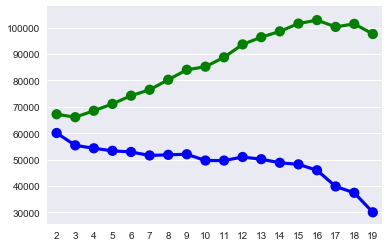

In [15]:
def elbow(k_max, X):
    elbow = {}
    aic = {}
    bic = {}
    for k in range(2,k_max):
        gm = gmm(n_components=k, random_state=0).fit(X)
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        elbow[k] = kmeans.inertia_
        aic[k] = gm.aic(X)
        bic[k] = gm.bic(X)
#     ax = sns.pointplot(x=list(elbow.keys()), y=list(elbow.values()), color='red')
    ax = sns.pointplot(x=list(aic.keys()), y=list(aic.values()), color='blue')
    ax = sns.pointplot(x=list(bic.keys()), y=list(bic.values()), color='green')
elbow(20, X_norm)

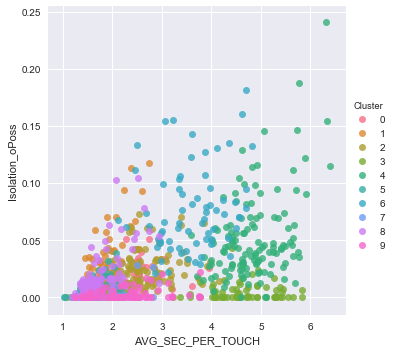

In [257]:
def groupPlot(x, y, k, df):
    df['Cluster'] = KMeans(n_clusters=k,
                         random_state=0).fit(X_norm).predict(X_norm)
    sns.lmplot(x, y, data=df, hue = 'Cluster', fit_reg=False,
#                scatter_kws={'alpha':0.7}
              )
groupPlot('AVG_SEC_PER_TOUCH', 'Isolation_oPoss', 10, df)

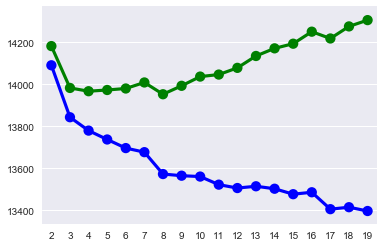

In [16]:
from sklearn.decomposition import PCA

def pcaDF(X):
    n = len(X[0])
    pca = PCA(n_components=n).fit_transform(X)
    cols = ['PC'+str(x+1) for x in range(n)]
    dfpca = pd.DataFrame(pca, columns=cols)
    return dfpca

dfpca = pcaDF(X_norm)

elbow(20, dfpca[['PC1', 'PC2', 'PC3']].values)

In [20]:
X_pca = dfpca[['PC1', 'PC2', 'PC3', 'PC4']].values
kmeans = KMeans(n_clusters=8, random_state=0).fit(X_pca)
dfpca['Cluster'] = kmeans.labels_
df['PCA_Cluster'] = dfpca['Cluster']
print(df.loc[df.sort_values('MIN', ascending=False).groupby('PCA_Cluster').head().index,
             ['DISPLAY_FIRST_LAST',
              'season', 'PCA_Cluster']
            ].sort_values('PCA_Cluster'))

           DISPLAY_FIRST_LAST  season  PCA_Cluster
2                  Al Horford    2015            0
522        Karl-Anthony Towns    2016            0
441              Gorgui Dieng    2016            0
15             Andre Drummond    2015            0
324             Anthony Davis    2016            0
92              DeMar DeRozan    2015            1
139            Gordon Hayward    2015            1
193               Joe Johnson    2015            1
257              LeBron James    2015            1
230  Kentavious Caldwell-Pope    2015            1
488              Jimmy Butler    2016            2
168              James Harden    2015            2
498                 John Wall    2016            2
469              James Harden    2016            2
225              Kemba Walker    2015            2
444           Harrison Barnes    2016            3
864              LeBron James    2017            3
437     Giannis Antetokounmpo    2016            3
136     Giannis Antetokounmpo  

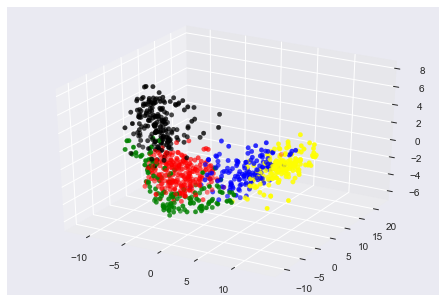

In [60]:
from mpl_toolkits.mplot3d import Axes3D

def plot3D(x, y, z, k, df):
    fig = plt.figure()
    ax = Axes3D(fig)
    df['Cluster'] = KMeans(n_clusters=k,
                         random_state=0).fit(X_norm).predict(X_norm)
    colors = {0:'red', 1:'blue', 2:'yellow', 3:'black', 4:'green'}
    ax.scatter(df[x].values,
               df[y].values,
               df[z].values, c = df['Cluster'].apply(lambda x: colors[x]))
plot3D('PC1', 'PC2', 'PC3', 5, dfpca)

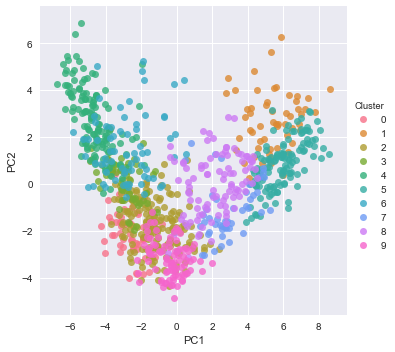

In [254]:
groupPlot('PC1', 'PC2', 10, dfpca)

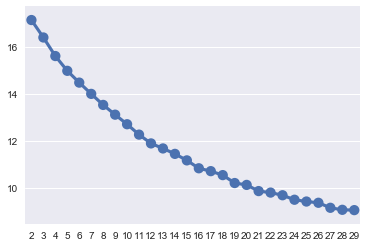

In [192]:
from sklearn.decomposition import FastICA

def icaDF(X):
    n = len(X[0])
    ica = FastICA(n_components=n).fit_transform(X)
    cols = ['IC'+str(x+1) for x in range(n)]
    dfica = pd.DataFrame(ica, columns=cols)
    return dfica

dfica = icaDF(X_norm)

elbow(30, dfica.values)

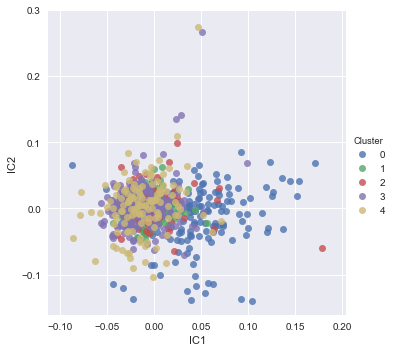

In [196]:
groupPlot('IC1', 'IC2', 5, dfica)

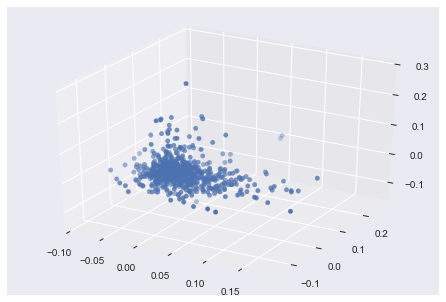

In [197]:


fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(dfica['IC1'].values,
           dfica['IC2'].values,
           dfica['IC3'].values)

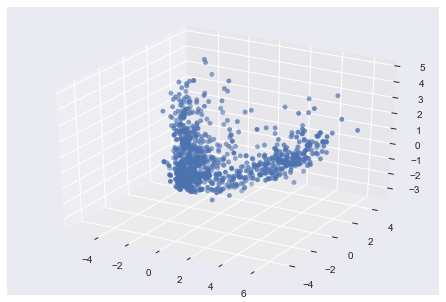

In [198]:
fig = plt.figure()
ax = Axes3D(fig)

colors = np.linspace(0, 1, len(dfpca.))

ax.scatter(dfpca['PC1'].values,
           dfpca['PC2'].values,
           dfpca['PC3'].values)